库

In [4]:
pip install opencv-python

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 147.0 kB/s eta 0:00:0000:0100:11
Note: you may need to restart the kernel to use updated packages.


In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import xml.etree.ElementTree as ET
import cv2
import os
import numpy as np
import codecs
import torch
from WordInfo import WordInfo

In [22]:
# 改变左右xml文件的encoding
xml_path = "/root/autodl-tmp/APS360_Project/Datasets/CVL_Unzip/cvl-database-1-1/trainset/xml"
for file in os.listdir(xml_path):
    with open(os.path.join(xml_path, file), 'r', encoding="unicode-escape") as f:
        content = f.read()
        idx = content.find("encoding=\"UTF-16\"")
        if idx != -1:
            content = content.replace("UTF-16", "UTF-8")
    with open(os.path.join(xml_path, file), 'w') as f:
        f.write(content)
            

crop 图像

In [90]:
# 定义源文件夹和目标文件夹路径
xml_source_folder = "/root/autodl-tmp/APS360_Project/Datasets/CVL_Unzip/cvl-database-1-1/trainset/xml"
image_folder = "/root/autodl-tmp/APS360_Project/Datasets/CVL_Unzip/cvl-database-1-1/trainset/pages"
image_target_folder = "/root/autodl-tmp/APS360_Project/Datasets/CVL_Processed/Images"
word_info_folder = "/root/autodl-tmp/APS360_Project/Datasets/CVL_Processed/word_info"

# 获取源文件夹所有xml文件
xml_files = [f for f in os.listdir(xml_source_folder) if f.endswith('.xml')]

# 获取目标文件夹所有图片文件
cropped_image_files = [f for f in os.listdir(image_target_folder) if f.endswith('.png')]


# 提取所有手写区域
namespaces = {'ns': 'http://schema.primaresearch.org/PAGE/gts/pagecontent/2010-03-19'}

# 遍历xml文件
for xml_file in xml_files:
    print(f"处理文件: {xml_file}")

    word_info_list = []

    # 构建源文件路径
    source_path = os.path.join(xml_source_folder, xml_file)

    # 解析XML文件
    tree = ET.parse(source_path)
    root = tree.getroot()

    try:
        # 找到手写部分的大框框
        handwritten_region = root.find(".//ns:AttrRegion[@attrType='3'][@fontType='2']", namespaces)
        # 找到这个大框框里面的所有单词的框框
        handwritten_words = handwritten_region.findall(".//ns:AttrRegion[@attrType='1']", namespaces)
    except AttributeError:
        print(f"文件格式错误: {xml_file}")
        continue

    # 生成对应的图像文件名
    image_file = xml_file.replace('_attributes.xml', '.tif')
    image_path = os.path.join(image_folder, image_file)

    # 读取图像
    img = cv2.imread(image_path)
    # 转为灰度图像
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if img is None:
        print(f"图像文件未找到: {image_path}")
        continue
    
    # 定义四个数组来储存每个单词的位置信息
    Xs, Ys, Xe, Ye = [], [], [], []
    
    # 遍历所有单词的框框
    for handwritten_word in handwritten_words:
        min_area_rect = handwritten_word.find(".//ns:minAreaRect", namespaces)
        points = min_area_rect.findall(".//ns:Point", namespaces)
        x_coords = [float(p.get('x')) for p in points]
        y_coords = [float(p.get('y')) for p in points]
        # 找到这个单词的框框的位置信息
        xS = min(x_coords)
        xE = max(x_coords)
        yS = min(y_coords)
        yE = max(y_coords)
        # 把这些位置信息存储到数组里
        Xs.append(xS)
        Xe.append(xE)
        Ys.append(yS)
        Ye.append(yE)
        # 添加到word_info_list
        word_info_list.append([xS, xE, yS, yE])
    
    # 找到手写体部分的大框框的位置信息
    min_Xs = min(Xs) - 10
    max_Xe = max(Xe) + 10
    min_Ys = min(Ys) - 10
    max_Ye = max(Ye) + 10
    
    # 裁剪图像
    img_cropped = img[int(min_Ys):int(max_Ye), int(min_Xs):int(max_Xe)]
    # 修改word_info_list中的位置信息
    for word_info in word_info_list:
        word_info[0] -= min_Xs
        word_info[1] -= min_Xs
        word_info[2] -= min_Ys
        word_info[3] -= min_Ys

    # 将图像用白色像素补成正方形
    height, width = img_cropped.shape
    if height > width:
        x = (height - width) // 2
        y = 0
        size = height
    else:
        x = 0
        y = (width - height) // 2
        size = width
    img_cropped = np.zeros((size, size), np.uint8)
    img_cropped.fill(255)
    img_cropped[y:y+height, x:x+width] = img[int(min_Ys):int(max_Ye), int(min_Xs):int(max_Xe)]
    # 修改word_info_list中的位置信息
    for word_info in word_info_list:
        word_info[0] += x
        word_info[1] += x
        word_info[2] += y
        word_info[3] += y

    # 调整至1024x1024
    img_resized = cv2.resize(img_cropped, (1024, 1024), interpolation=cv2.INTER_AREA)
    # 修改word_info_list中的位置信息
    factor = 1024 / width
    for word_info in word_info_list:
        word_info[0] *= factor
        word_info[1] *= factor
        word_info[2] *= factor
        word_info[3] *= factor
    
    # 创建word_info_list对象
    new_word_info_list = []
    for word_info in word_info_list:
        x = word_info[0]
        y = word_info[2]
        w = word_info[1] - word_info[0]
        h = word_info[3] - word_info[2]
        wi = WordInfo("temp", "ok", 123, x, y, w, h, "temp", "temp")
        new_word_info_list.append(wi)

    # 重新命名文件
    processed_image_file = xml_file.replace('_attributes.xml', '.png')

    # 生成保存处理后的图像路径
    processed_image_path = os.path.join(image_target_folder, processed_image_file)

    # 保存处理后的图像
    cv2.imwrite(processed_image_path, img_resized)
    # 保存tensor
    img_resized_tensor = torch.tensor(img_resized, dtype=torch.float).reshape(1, 1024, 1024)
    img_resized_file = xml_file.replace('_attributes.xml', '.pt')
    img_resized_path = os.path.join(image_target_folder, img_resized_file)
    torch.save(img_resized_tensor, img_resized_path)
    # 保存word_info_list
    word_info_file = xml_file.replace('_attributes.xml', '.pt')
    word_info_path = os.path.join(word_info_folder, word_info_file)
    torch.save(new_word_info_list, word_info_path)

print("图像处理完成")


处理文件: 0012-1_attributes.xml
处理文件: 0001-1_attributes.xml
处理文件: 0006-8_attributes.xml
处理文件: 0001-2_attributes.xml
处理文件: 0012-2_attributes.xml
处理文件: 0001-3_attributes.xml
处理文件: 0012-3_attributes.xml
处理文件: 0001-4_attributes.xml
处理文件: 0013-1_attributes.xml
处理文件: 0001-6_attributes.xml
处理文件: 0013-2_attributes.xml
处理文件: 0001-7_attributes.xml
处理文件: 0013-3_attributes.xml
处理文件: 0001-8_attributes.xml
处理文件: 0013-4_attributes.xml
处理文件: 0002-1_attributes.xml
处理文件: 0013-6_attributes.xml
处理文件: 0002-2_attributes.xml
处理文件: 0013-7_attributes.xml
处理文件: 0002-3_attributes.xml
处理文件: 0013-8_attributes.xml
处理文件: 0002-4_attributes.xml
处理文件: 0014-1_attributes.xml
处理文件: 0002-6_attributes.xml
处理文件: 0014-2_attributes.xml
处理文件: 0002-7_attributes.xml
处理文件: 0014-3_attributes.xml
处理文件: 0002-8_attributes.xml
处理文件: 0014-4_attributes.xml
处理文件: 0003-1_attributes.xml
处理文件: 0014-6_attributes.xml
处理文件: 0003-2_attributes.xml
处理文件: 0014-7_attributes.xml
处理文件: 0003-3_attributes.xml
处理文件: 0014-8_attributes.xml
处理文件: 0003-4_attribu

file name: 0234-3.pt
[WordInfo(temp, True, 123, 24, 190, 169, 48, temp, temp), WordInfo(temp, True, 123, 211, 198, 32, 37, temp, temp), WordInfo(temp, True, 123, 264, 209, 37, 25, temp, temp), WordInfo(temp, True, 123, 333, 200, 140, 40, temp, temp), WordInfo(temp, True, 123, 490, 205, 149, 32, temp, temp), WordInfo(temp, True, 123, 665, 193, 47, 44, temp, temp), WordInfo(temp, True, 123, 723, 198, 49, 39, temp, temp), WordInfo(temp, True, 123, 794, 197, 57, 49, temp, temp), WordInfo(temp, True, 123, 871, 198, 146, 42, temp, temp), WordInfo(temp, True, 123, 14, 289, 138, 42, temp, temp), WordInfo(temp, True, 123, 174, 284, 84, 49, temp, temp), WordInfo(temp, True, 123, 271, 300, 40, 20, temp, temp), WordInfo(temp, True, 123, 327, 284, 146, 37, temp, temp), WordInfo(temp, True, 123, 481, 298, 46, 24, temp, temp), WordInfo(temp, True, 123, 539, 287, 49, 35, temp, temp), WordInfo(temp, True, 123, 601, 278, 128, 39, temp, temp), WordInfo(temp, True, 123, 740, 293, 152, 27, temp, temp), Wor

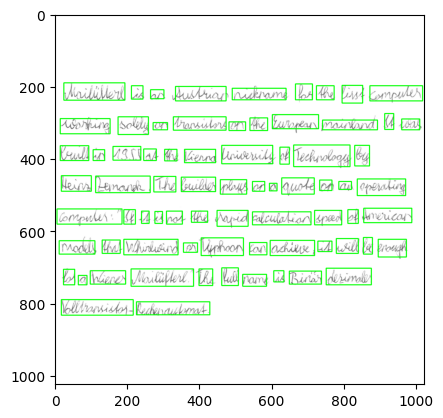

In [88]:
# 抽查生成的data和label是否正确
import random
import torch
import cv2
from WordInfo import WordInfo

# 定义源文件夹和目标文件夹路径
image_folder = "/root/autodl-tmp/APS360_Project/Datasets/CVL_Processed/Images"
word_info_folder = "/root/autodl-tmp/APS360_Project/Datasets/CVL_Processed/word_info"

# 抽取一个幸运文件
word_info_files = [f for f in os.listdir(word_info_folder) if f.endswith('.pt')]
word_info_file = random.choice(word_info_files)
word_info_path = os.path.join(word_info_folder, word_info_file)
image_path = os.path.join(image_folder, word_info_file.replace('.pt', '.png'))
print(f"file name: {word_info_file}")

# 读取图像
img = cv2.imread(image_path)
# 读取word_info_list
word_info_list = torch.load(word_info_path)
# 在图像上画出所有单词的框框
for wi in word_info_list:
    cv2.rectangle(img, (wi.x, wi.y), (wi.x + wi.w, wi.y + wi.h), (0, 255, 0), 2)
# 显示图像
plt.imshow(img)

print(word_info_list)

将以上函数模块化以便日后使用

In [10]:
# 给定xml文件名字，寻找目标位置
def find_location(xml_file):
    # 构建源文件路径
    source_path = os.path.join(xml_source_folder, xml_file)

    # 解析XML文件
    tree = ET.parse(source_path)
    root = tree.getroot()

    # 找到手写部分的大框框
    handwritten_region = root.find(".//ns:AttrRegion[@attrType='3'][@fontType='2']", namespaces)
    # 找到这个大框框里面的所有单词的框框
    handwritten_words = handwritten_region.findall(".//ns:AttrRegion[@attrType='1']", namespaces)

    # 生成对应的图像文件名
    image_file = xml_file.replace('_attributes.xml', '.tif')
    image_path = os.path.join(image_folder, image_file)

    # 读取图像
    img = cv2.imread(image_path)

    # 转为灰度图像
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 定义四个数组来储存每个单词的位置信息
    Xs, Ys, Xe, Ye = [], [], [], []
    
    # 遍历所有单词的框框
    for handwritten_word in handwritten_words:
        min_area_rect = handwritten_word.find(".//ns:minAreaRect", namespaces)
        points = min_area_rect.findall(".//ns:Point", namespaces)
        x_coords = [float(p.get('x')) for p in points]
        y_coords = [float(p.get('y')) for p in points]
        # 找到这个单词的框框的位置信息
        xS = min(x_coords)
        xE = max(x_coords)
        yS = min(y_coords)
        yE = max(y_coords)
        # 把这些位置信息存储到数组里
        Xs.append(xS)
        Xe.append(xE)
        Ys.append(yS)
        Ye.append(yE)
    
    # 找到手写体部分的大框框的位置信息
    min_Xs = min(Xs) - 10
    max_Xe = max(Xe) + 10
    min_Ys = min(Ys) - 10
    max_Ye = max(Ye) + 10

    return min_Xs, max_Xe, min_Ys, max_Ye


In [4]:
# 给定坐标，裁剪图像
def crop_image(img, min_Xs, max_Xe, min_Ys, max_Ye):
    # 裁剪图像
    assert max_Xe <= img.shape[0] and max_Ye <= img.shape[1] and min_Xs >= 0 and min_Ys >= 0, "裁剪区域超出图像范围"
    img_cropped = img[int(min_Ys):int(max_Ye), int(min_Xs):int(max_Xe)]

    # 图片长边缩放至1024
    if img_cropped.shape[0] > img_cropped.shape[1]:
        img_resized = cv2.resize(img_cropped, (1024, int(1024 / img_cropped.shape[0] * img_cropped.shape[1])), interpolation=cv2.INTER_AREA)
    else:
        img_resized = cv2.resize(img_cropped, (int(1024 / img_cropped.shape[1] * img_cropped.shape[0]), 1024), interpolation=cv2.INTER_AREA)
    
    

    # 准备变换函数
    def transform(x, y):
        x = (x - min_Xs) / (max_Xe - min_Xs) * 1024
        y = (y - min_Ys) / (max_Ye - min_Ys) * 1024
        return x, y

    return img_resized, transform

In [5]:
# 给定图像数据，保存处理后的图像到指定路径
def store_img(processed_image_file, target_folder_path):
    # 生成保存处理后的图像路径
    processed_image_path = os.path.join(target_folder_path, processed_image_file)

    # 保存处理后的图像
    cv2.imwrite(processed_image_path, img_resized)

将xml文件中的参数打包并保存

In [9]:
from WordInfo import WordInfo
import torch
import os
from xml.etree import ElementTree as ET

# 获取源文件夹所有xml文件
xml_files = [f for f in os.listdir(xml_source_folder) if f.endswith('.xml')]

# 提取所有手写区域
namespaces = {'ns': 'http://schema.primaresearch.org/PAGE/gts/pagecontent/2010-03-19'}

for xml_file in xml_files:

    # 构建源文件路径
    xml_file_path = os.path.join(xml_source_folder, xml_file)

    # 找到手写单词的大边框
    xS, xE, yS, yE = find_location(xml_file)

    # 解析XML文件
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    # 找到手写部分的大框框
    handwritten_region = root.find(".//ns:AttrRegion[@attrType='3'][@fontType='2']", namespaces)
    # 找到这个大框框里面的所有单词的框框
    handwritten_words = handwritten_region.findall(".//ns:AttrRegion[@attrType='1']", namespaces)
    words = []

    for handwritten_word in handwritten_words:
        
        # 从xml中找到这个单词的位置信息
        min_area_rect = handwritten_word.find(".//ns:minAreaRect", namespaces)
        points = min_area_rect.findall(".//ns:Point", namespaces)
        x_coords = [float(p.get('x')) for p in points]
        y_coords = [float(p.get('y')) for p in points]

        # 找到这个单词的框框的位置信息
        xS = min(x_coords)
        xE = max(x_coords)
        yS = min(y_coords)
        yE = max(y_coords)

        # 计算width，height
        width = abs(xE - xS)
        height = abs(yE - yS)

        # 从xml中找到这个单词的id信息
        id_info = handwritten_word.get('id')

        # 从xml中找到这个单词的text信息
        text_info = handwritten_word.get('text')

        # 创建WordInfo对象
        word = WordInfo(id_info, "ok", 0, xS, yS, width, height, "None", text_info)

        # 将WordInfo对象加入到words数组中
        words.append(word)

        # 打印WordInfo信息
        print(word)
    
    # 保存WordInfo 为 pt 文件到指定文件夹
    word_info_target_folder = "/root/autodl-tmp/APS360_Project/Datasets/CVL_Processed/word_info"
    word_info_file = xml_file.replace('_attributes.xml', '.pt')
    word_info_path = os.path.join(word_info_target_folder, word_info_file)
    torch.save(words, word_info_path)

print("WordInfo处理完成")


WordInfo(0012-1-0-0, True, 0, 315, 965, 314, 75, None, Imagine)
WordInfo(0012-1-0-1, True, 0, 706, 965, 65, 32, None, a)
WordInfo(0012-1-0-2, True, 0, 808, 917, 154, 82, None, vast)
WordInfo(0012-1-0-3, True, 0, 1013, 918, 196, 88, None, sheet)
WordInfo(0012-1-0-4, True, 0, 1264, 918, 88, 113, None, of)
WordInfo(0012-1-0-5, True, 0, 1406, 961, 241, 96, None, paper)
WordInfo(0012-1-0-6, True, 0, 1716, 967, 98, 36, None, on)
WordInfo(0012-1-0-7, True, 0, 1870, 903, 226, 112, None, which)
WordInfo(0012-1-1-0, True, 0, 436, 1068, 18, 14, None, None)
WordInfo(0012-1-1-1, True, 0, 301, 1059, 293, 131, None, straight)
WordInfo(0012-1-1-2, True, 0, 665, 1060, 189, 131, None, Lines)
WordInfo(0012-1-1-3, True, 0, 860, 1061, 121, 13, None, None)
WordInfo(0012-1-1-4, True, 0, 921, 1061, 302, 135, None, Triangles)
WordInfo(0012-1-1-5, True, 0, 1213, 1163, 16, 20, None, None)
WordInfo(0012-1-1-6, True, 0, 1266, 1066, 311, 127, None, Squares)
WordInfo(0012-1-1-7, True, 0, 1578, 1159, 24, 15, None, No

将image转换成pt文件

In [13]:
# 转换段落图像
for image_file in cropped_image_files:
    # 构建路径
    image_path = os.path.join(image_target_folder, image_file)

    # 读取图像
    img = cv2.imread(image_path)

    # 将图像转成tensor
    img_tensor = torch.tensor(img)

    # 创建pt文件
    processed_image_pt_file = image_file.replace('.png', '.pt')

    # 生成保存处理后的图像路径
    processed_image_pt_path = os.path.join(image_target_folder, processed_image_pt_file)

    # 保存处理后的pt文件
    torch.save(img_tensor, processed_image_pt_path)

print("文件处理完成")

文件处理完成


In [2]:
import cv2
import os
import torch

# 定义源文件夹(父)
image_father_folder = "/root/autodl-tmp/APS360_Project/Datasets/CVL_Unzip/cvl-database-1-1/trainset/words"

# 定义目标文件夹
image_word_target_folder = "/root/autodl-tmp/APS360_Project/Datasets/CVL_Processed/Images/Images_word_pt"

# 转换段落图像
# 遍历父文件夹
for son_folder in os.listdir(image_father_folder):
    # 定义源文件夹(子)
    image_son_folder = os.path.join(image_father_folder, son_folder)
    
    # 遍历子文件夹
    for image_file in os.listdir(image_son_folder):
        # 构建tif文件路径
        image_path = os.path.join(image_son_folder, image_file)
        
        # 读取图像
        img = cv2.imread(image_path)

        # 将图像用白色像素补成正方形
        height, width, _ = img.shape
        difference = abs(height - width)
        # 如果相差是偶数
        if difference % 2 == 0:
            paddling = difference // 2
            img = cv2.copyMakeBorder(img, paddling, paddling, 0, 0, cv2.BORDER_CONSTANT, value=[255, 255, 255])
        # 如果相差是奇数
        else:
            paddling = difference // 2
            img = cv2.copyMakeBorder(img, paddling, paddling + 1, 0, 0, cv2.BORDER_CONSTANT, value=[255, 255, 255])

        # 调整至128x128
        img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)

        # 转成灰度图像
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # 将图像转成tensor
        img_tensor = torch.tensor(img)

        # 创建pt文件
        processed_image_pt_file = image_file.replace('.tif','.pt')

        # 生成保存处理后的图像路径
        processed_image_pt_path = os.path.join(image_word_target_folder, processed_image_pt_file)

        # 保存处理后的pt文件
        torch.save(img_tensor, processed_image_pt_path)
